# Trajectory Smoothing

In this notebook a pipeline is implemented and tested to smoothen the trajedctory of the ball tracking and possibly further increasing detection performance

### imports

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
import random
from scipy.interpolate import CubicSpline
from scipy.spatial import distance

## load data

In [6]:
# read annotation json
with open('../00_Dataset/annotations_complete.json') as f:
    data = json.load(f)

In [5]:
# read test results TN csv
predictions = pd.read_csv('../03_BallTracking/results/Pre_Results_TN.csv')

# Convert the 'version' column from string representation of dictionaries to actual dictionaries
predictions['version'] = predictions['version'].apply(eval)  # Use eval to convert strings to dictionaries

# convert the 'version' column to multiple columns
predictions = pd.concat([predictions.drop(['version'], axis=1), predictions['version'].apply(pd.Series)], axis=1)

# filter for augmentation true, input 5 output 5
predictions = predictions[(predictions['augmentation'] == True) & (predictions['input_number'] == 5) & (predictions['output_number'] == 5)]

# get frame results
predictions = predictions['frame_results']

# convert from string to list
predictions = predictions.apply(eval)

# get the first frame results
test_predictions = predictions.iloc[0]

# scale up positions to original size
def scale_up_position(position):
    return (position[0] * 2.5, position[1] * 2.5)

for frame in test_predictions:
        frame['predicted_position'] = scale_up_position(frame['predicted_position'])
        frame['ground_truth_position'] = scale_up_position(frame['ground_truth_position'])

test_predictions[0]

{'subset': 'New',
 'video': 'Video_1',
 'clip': 'clip_6',
 'frame': '53',
 'points': [{'x': 366, 'y': 552, 'visibility': 'Visible'}],
 'window_index': np.int64(0),
 'predicted_position': (362.5, 550.0),
 'ground_truth_position': (365.0, 550.0)}

## Testing around

In [7]:
[x['name'] for x in data["subsets"][0]["videos"]]

['Video_1', 'Video_2', 'Video_3', 'Video_4', 'Video_5', 'Video_6']

In [8]:
# get video 6 clip 1
clip = data["subsets"][0]["videos"][5]["clips"][0]

In [9]:
ball_positions = []
hits = []
bounces = []
# loop over frames
for frame, objects in clip["frames_with_objects"].items():
    if len(objects['balls']) > 0:
        ball_positions.append((objects['balls'][0]['x'], objects['balls'][0]['y']))
        if objects['balls'][0]['trajectory'] == 'Hit':
            hits.append((objects['balls'][0]['x'], objects['balls'][0]['y']))
        elif objects['balls'][0]['trajectory'] == 'Bounce':
            bounces.append((objects['balls'][0]['x'], objects['balls'][0]['y']))
    else:
        ball_positions.append((None, None))

print(hits)
print(bounces)

[(808, 135), (526, 245), (353, 258), (705, 244)]
[(861, 510), (567, 312), (410, 390), (654, 305), (844, 334)]


In [10]:
# get positions from test_predtictions where subset = New video = Video_1 and clip = clip_1
clip_1 = [x for x in test_predictions if x['subset'] == 'New' and x['video'] == 'Video_6' and x['clip'] == 'clip_1']
# order by int(frame)
clip_1 = sorted(clip_1, key=lambda x: int(x['frame']))
# replace -2.5 with None
clip_1 = [{**x, 'predicted_position': (None, None) if x['predicted_position'] == (-2.5, -2.5) else x['predicted_position']} for x in clip_1]
ball_positions2 = np.array([[x['predicted_position'][0] , x['predicted_position'][1]] for x in clip_1])
clip_1[200]

{'subset': 'New',
 'video': 'Video_6',
 'clip': 'clip_1',
 'frame': '200',
 'points': [{'x': 390, 'y': 296, 'visibility': 'Visible'}],
 'window_index': np.int64(375),
 'predicted_position': (387.5, 295.0),
 'ground_truth_position': (390.0, 295.0)}

### visualization

C:\Users\benev\AppData\Local\Temp\ipykernel_20536\3083761174.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()


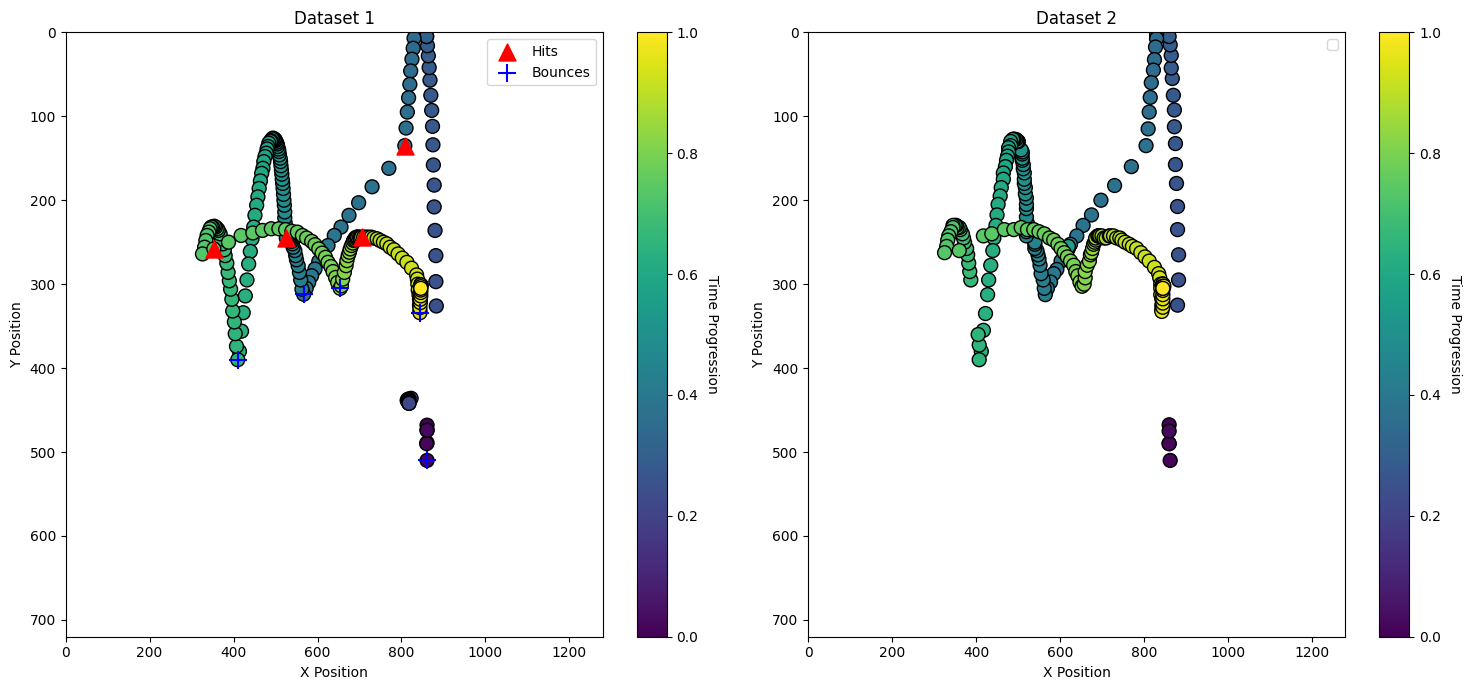

In [ ]:
# plot ball positions
ball_positions1 = np.array(ball_positions)
hits1 = np.array(hits)
bounces1 = np.array(bounces)

# Simulated time for both datasets
time1 = np.linspace(0, 1, len(ball_positions1))
time2 = np.linspace(0, 1, len(ball_positions2))

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Plot for the first dataset
axes[0].scatter(ball_positions1[:, 0], ball_positions1[:, 1], c=time1, cmap='viridis', s=100, edgecolor='k')
if hits1.size > 0:
    axes[0].scatter(hits1[:, 0], hits1[:, 1], color='red', label='Hits', marker='^', s=150)
if bounces1.size > 0:
    axes[0].scatter(bounces1[:, 0], bounces1[:, 1], color='blue', label='Bounces', marker='+', s=150)

# Customize the first subplot
axes[0].invert_yaxis()
axes[0].set_xlim(0, 1280)
axes[0].set_ylim(720, 0)
axes[0].set_xlabel("X Position")
axes[0].set_ylabel("Y Position")
axes[0].set_title("Dataset 1")
axes[0].legend()
cbar1 = fig.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=axes[0])
cbar1.set_label("Time Progression", rotation=270, labelpad=15)

# Plot for the second dataset
axes[1].scatter(ball_positions2[:, 0], ball_positions2[:, 1], c=time2, cmap='viridis', s=100, edgecolor='k')

# Customize the second subplot
axes[1].invert_yaxis()
axes[1].set_xlim(0, 1280)
axes[1].set_ylim(720, 0)
axes[1].set_xlabel("X Position")
axes[1].set_ylabel("Y Position")
axes[1].set_title("Dataset 2")
axes[1].legend()
cbar2 = fig.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=axes[1])
cbar2.set_label("Time Progression", rotation=270, labelpad=15)

# Show the plot
plt.tight_layout()
plt.show()

### Kalman filter test

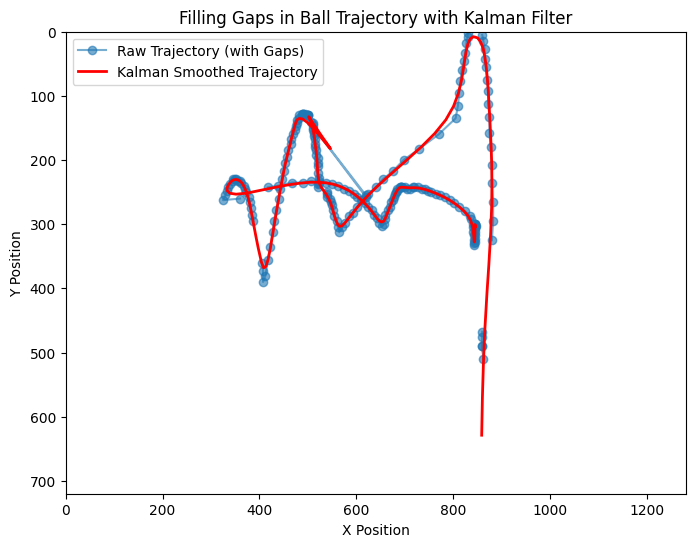

In [12]:
# Separate x and y coordinates, replace None with np.nan
x_positions = np.array([pos[0] if pos is not None else np.nan for pos in ball_positions2], dtype=float)
y_positions = np.array([pos[1] if pos is not None else np.nan for pos in ball_positions2], dtype=float)

# Indices where data is available
valid_idx = ~np.isnan(x_positions)
time = np.arange(len(ball_positions2))  # Time or frame indices

# Kalman filter parameters
kf = KalmanFilter(
    transition_matrices=[[1, 1], [0, 1]],  # State transition matrix (constant velocity model)
    observation_matrices=[[1, 0]],         # Observation matrix
    initial_state_mean=[x_positions[valid_idx][0], 0],  # Initial state: [position, velocity]
    initial_state_covariance=[[1, 0], [0, 1]],         # Initial uncertainty
    observation_covariance=1,                         # Measurement noise
    transition_covariance=[[0.1, 0], [0, 0.1]]        # Process noise
)

# Smooth x and y positions independently
smoothed_x, _ = kf.smooth(x_positions[valid_idx])
smoothed_y, _ = kf.smooth(y_positions[valid_idx])

# Interpolate smoothed positions for all frames
x_filled = np.interp(time, time[valid_idx], smoothed_x[:, 0])  # Interpolation for gaps
y_filled = np.interp(time, time[valid_idx], smoothed_y[:, 0])

# Combine x and y back into positions
filled_positions = np.column_stack((x_filled, y_filled))

# Plot the raw and filled trajectory
plt.figure(figsize=(8, 6))
plt.plot(x_positions, y_positions, 'o-', label="Raw Trajectory (with Gaps)", alpha=0.6)
plt.plot(x_filled, y_filled, 'r-', label="Kalman Smoothed Trajectory", linewidth=2)
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.gca().invert_yaxis()  # Match screen coordinates
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.title("Filling Gaps in Ball Trajectory with Kalman Filter")
plt.legend()
plt.show()

### cubic spline test

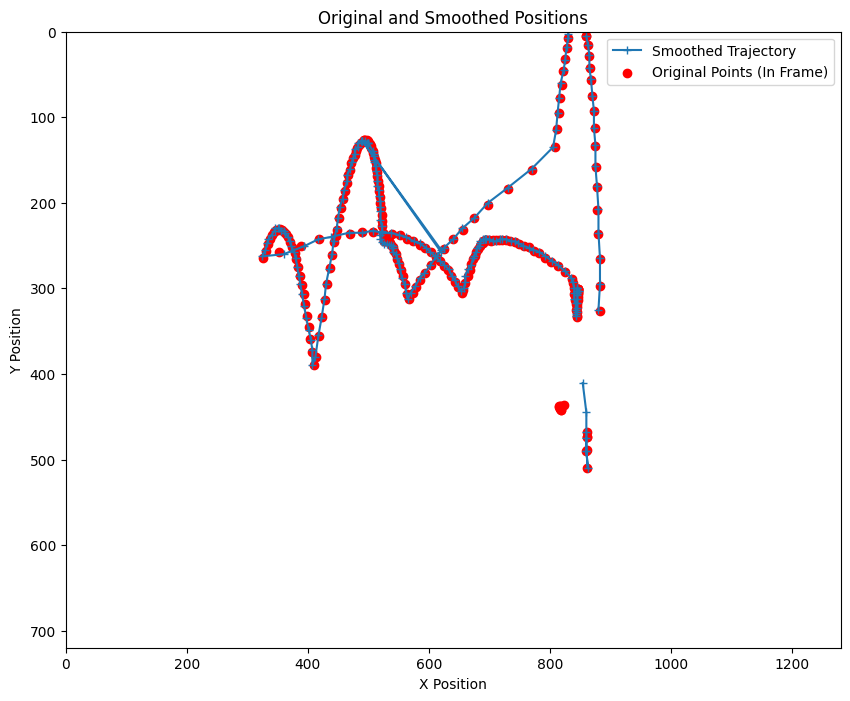

In [10]:
def fill_gaps_with_spline(ball_positions, frame_width, frame_height, window_size=4, max_gap_length=10):
    # Prepare x and y positions, replacing None with NaN
    x_positions = np.array([pos[0] if pos is not None else np.nan for pos in ball_positions], dtype=float)
    y_positions = np.array([pos[1] if pos is not None else np.nan for pos in ball_positions], dtype=float)

    # Remove points outside the frame
    valid_in_frame = (
        (x_positions >= 0) & (x_positions <= frame_width) & 
        (y_positions >= 0) & (y_positions <= frame_height)
    )
    x_positions[~valid_in_frame] = np.nan
    y_positions[~valid_in_frame] = np.nan

    # Time (frame indices)
    time = np.arange(len(ball_positions))

    # Helper function to find gaps
    def find_gaps(data):
        is_nan = np.isnan(data)
        gaps = []
        start = None
        for i, nan in enumerate(is_nan):
            if nan and start is None:
                start = i
            elif not nan and start is not None:
                gaps.append((start, i))
                start = None
        if start is not None:
            gaps.append((start, len(data)))
        return gaps

    # Identify gaps in the data
    gaps = find_gaps(x_positions)

    # Fill each gap with an enlarged time window
    for start, end in gaps:
        gap_length = end - start
        # Only process gaps smaller than or equal to max_gap_length
        if gap_length <= max_gap_length:
            # Define the interpolation range: Include more points before and after the gap
            interp_start = max(0, start - window_size)  # Include window_size points before
            interp_end = min(len(x_positions), end + window_size)  # Include window_size points after

            # Valid indices for interpolation
            valid_range = time[interp_start:interp_end][~np.isnan(x_positions[interp_start:interp_end])]
            valid_x = x_positions[interp_start:interp_end][~np.isnan(x_positions[interp_start:interp_end])]
            valid_y = y_positions[interp_start:interp_end][~np.isnan(y_positions[interp_start:interp_end])]

            if len(valid_x) >= 3:  # Need at least 3 points for cubic spline
                # Fit splines for x and y
                spline_x = CubicSpline(valid_range, valid_x, bc_type='natural')
                spline_y = CubicSpline(valid_range, valid_y, bc_type='natural')

                # Fill the gap
                gap_range = time[start:end]
                x_positions[start:end] = spline_x(gap_range)
                y_positions[start:end] = spline_y(gap_range)

    return x_positions, y_positions



def plot_positions(original_positions, smoothed_x, smoothed_y, frame_width, frame_height):
    # Prepare x and y positions from the original data
    original_x = [pos[0] if pos is not None else np.nan for pos in original_positions]
    original_y = [pos[1] if pos is not None else np.nan for pos in original_positions]

    # Plot the results
    plt.figure(figsize=(10, 8))
    plt.plot(smoothed_x, smoothed_y, '-+', label="Smoothed Trajectory")  # Smoothed trajectory
    plt.scatter(
        [x for x, y in zip(original_x, original_y) if x is not None and 0 <= x <= frame_width and 0 <= y <= frame_height],
        [y for x, y in zip(original_x, original_y) if x is not None and 0 <= x <= frame_width and 0 <= y <= frame_height],
        color='red', label="Original Points (In Frame)"
    )
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.title("Original and Smoothed Positions")
    plt.gca().invert_yaxis()  # Match screen coordinates
    plt.xlim(0, frame_width)
    plt.ylim(frame_height, 0)
    plt.legend()
    plt.show()

FRAME_WIDTH = 1280
FRAME_HEIGHT = 720

# Fill gaps
smoothed_x, smoothed_y = fill_gaps_with_spline(ball_positions2, FRAME_WIDTH, FRAME_HEIGHT, window_size=4)

# Plot the results
plot_positions(ball_positions, smoothed_x, smoothed_y, FRAME_WIDTH, FRAME_HEIGHT)


### outlier detection

[166 167 220 222]


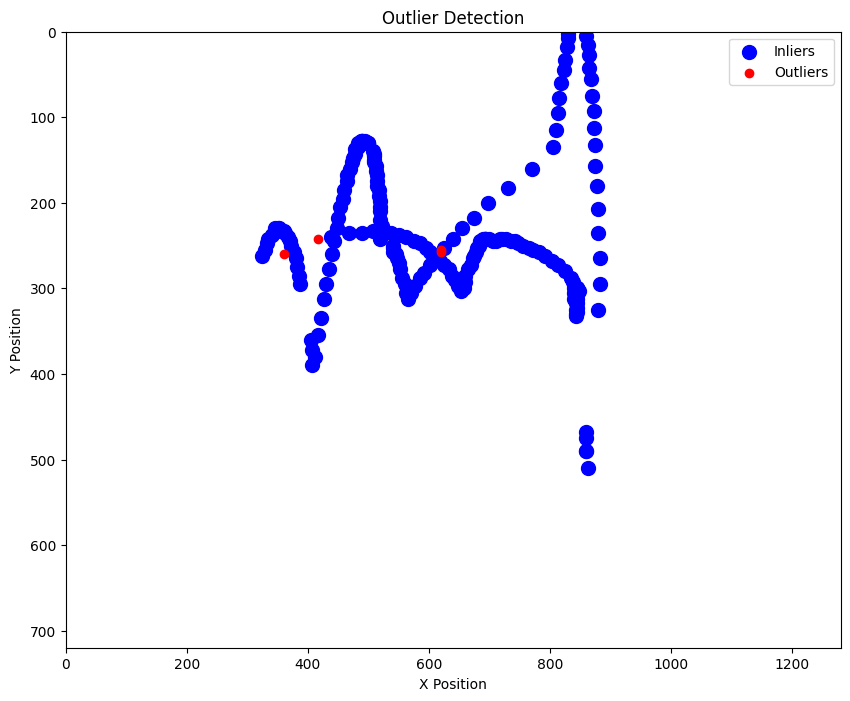

In [69]:
def detect_outliers(ball_positions, max_change = 200, threshold = 50, window_size = 5):

    # Check for valid input
    if len(ball_positions) < window_size:
        raise ValueError("Number of positions must be greater than the sliding window size.")

    # Method 1: Positional change check
    large_change_indexes = positional_change_check(ball_positions, max_change)

    # remove the detected outliers
    ball_positions = [pos if i not in large_change_indexes else (None, None) for i, pos in enumerate(ball_positions)]

    # Method 2: Cubic spline sliding window
    spline_outlier_indexes = cubic_spline_outlier_detection(ball_positions, threshold, window_size)

    # Combine results from both methods
    outliers = np.unique(np.concatenate([large_change_indexes, spline_outlier_indexes]))

    return outliers

def positional_change_check(ball_positions, max_change):
    outlier_indexes = []
    #iterate over the ball positions and calculate the euclidean distance between each pair of consecutive positions
    for i in range(1, len(ball_positions)):
        #calculate the euclidean distance between the current position and the previous position
        current_position = ball_positions[i]
        previous_position = ball_positions[i-1]
        #check if both have a value
        if current_position[0] is not None and current_position[1] is not None and previous_position[0] is not None and previous_position[1] is not None:

            distance = np.linalg.norm(np.array(ball_positions[i]) - np.array(ball_positions[i-1]))
            #if the distance is greater than the max_change threshold add to the outlier indexes
            if distance > max_change:
                outlier_indexes.append(i)

    # if i have indexes with a gap of 1 in between liek 166 and 168 add 167 to the outlier indexes
    for i in range(1, len(outlier_indexes)):
        if outlier_indexes[i] - outlier_indexes[i-1] == 2:
            outlier_indexes.append(outlier_indexes[i] - 1)

    # if i have a sequence of at least 3 outlies in a row the last one is probably not an outlier
    outlier_indexes = sorted(outlier_indexes)
    for i in range(2, len(outlier_indexes)):
        if outlier_indexes[i] - outlier_indexes[i-1] == 1 and outlier_indexes[i-1] - outlier_indexes[i-2] == 1:
            outlier_indexes.pop(i)

    return outlier_indexes

def predict_next_position_cubic(positions):
    # Extract x and y coordinates, replacing None with np.nan for consistency
    x_positions = np.array([pos[0] if pos[0] is not None else np.nan for pos in positions], dtype=float)
    y_positions = np.array([pos[1] if pos[1] is not None else np.nan for pos in positions], dtype=float)

    # Time (frame indices)
    time = np.arange(len(positions))

    # Count the number of NaN values
    num_nan_x = np.isnan(x_positions).sum()
    num_nan_y = np.isnan(y_positions).sum()

    # Check if more than half the points are NaN
    if num_nan_x > len(positions) // 2 or num_nan_y > len(positions) // 2:
        return (np.nan, np.nan), False # Too many missing values

    # Interpolate missing values with linear interpolation
    x_positions = np.interp(time, time[~np.isnan(x_positions)], x_positions[~np.isnan(x_positions)])
    y_positions = np.interp(time, time[~np.isnan(y_positions)], y_positions[~np.isnan(y_positions)])

    # Fit cubic splines
    spline_x = CubicSpline(time, x_positions, bc_type='natural')
    spline_y = CubicSpline(time, y_positions, bc_type='natural')

    # Predict the next position
    next_time = time[-1] + 1
    next_x = spline_x(next_time)
    next_y = spline_y(next_time)

    return (next_x, next_y), True

def cubic_spline_outlier_detection(ball_positions, threshold, window_size):
    n_positions = len(ball_positions)
    outlier_indexes = []

    for i in range(n_positions):
        # Skip boundary positions where we can't apply the sliding window
        if i < window_size or i >= n_positions - window_size:
            continue

        # If the current position is None, skip
        if ball_positions[i][0] is None or ball_positions[i][1] is None:
            continue

        # Fit cubic splines for preceding and subsequent windows
        prev_indices = range(i - window_size, i)
        next_indices = range(i + 1, i + 1 + window_size)

        # Filter valid positions for both windows
        positions_before = np.array([ball_positions[idx] for idx in prev_indices])
        positions_after = np.array([ball_positions[idx] for idx in next_indices])

        # reverse the positions after 
        positions_after = positions_after[::-1]

        # predict the next position using the cubic spline
        prediction_prev, success_prev = predict_next_position_cubic(positions_before)
        predictions_after, success_after = predict_next_position_cubic(positions_after)

        # If either prediction fails, skip
        if not success_prev or not success_after:
            continue

        # Convert current position to numpy array
        current_position = np.array(ball_positions[i])

        # Calculate Euclidean distances
        dist_prev = np.linalg.norm(prediction_prev - current_position)
        dist_next = np.linalg.norm(predictions_after - current_position)

        # Use the smaller of the two distances
        distance = min(dist_prev, dist_next)

        # If the distance is greater than the threshold, mark as an outlier
        if distance > threshold:
            outlier_indexes.append(i)

    return outlier_indexes


# plot outliers
def plot_outliers(original_positions, outlier_indexes, frame_width, frame_height):
    # Prepare x and y positions from the original data
    original_x = [pos[0] if pos is not None else np.nan for pos in original_positions]
    original_y = [pos[1] if pos is not None else np.nan for pos in original_positions]

    # Plot the results
    plt.figure(figsize=(10, 8))
    plt.scatter(
        [x for i, x in enumerate(original_x) if i not in outlier_indexes],
        [y for i, y in enumerate(original_y) if i not in outlier_indexes],
        color='blue', label="Inliers", s=100
    )
    plt.scatter(
        [x for i, x in enumerate(original_x) if i in outlier_indexes],
        [y for i, y in enumerate(original_y) if i in outlier_indexes],
        color='red', label="Outliers"
    )
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.title("Outlier Detection")
    plt.gca().invert_yaxis()  # Match screen coordinates
    plt.xlim(0, frame_width)
    plt.ylim(frame_height, 0)
    plt.legend()
    plt.show()

# Detect outliers
outliers = detect_outliers(ball_positions2, max_change=160, threshold=10, window_size=6)
print(outliers)
plot_outliers(ball_positions2, outliers, FRAME_WIDTH, FRAME_HEIGHT)


In [70]:
# print indexes 165-170 as index: 169 position: x,y
for i in range(215, 230):
    print(f"index: {i} position: {ball_positions2[i]}")

index: 215 position: [340.0 237.5]
index: 216 position: [335.0 242.5]
index: 217 position: [332.5 247.5]
index: 218 position: [330.0 255.0]
index: 219 position: [325.0 262.5]
index: 220 position: [360.0 260.0]
index: 221 position: [None None]
index: 222 position: [417.5 242.5]
index: 223 position: [437.5 240.0]
index: 224 position: [467.5 235.0]
index: 225 position: [490.0 235.0]
index: 226 position: [507.5 232.5]
index: 227 position: [522.5 235.0]
index: 228 position: [537.5 235.0]
index: 229 position: [550.0 237.5]


## Smoothing Pipeline implementation

In [153]:
def fill_gaps_with_spline(ball_positions, frame_width, frame_height, window_size=4, max_gap_length=5):
    # Prepare x and y positions, replacing None with NaN
    x_positions = np.array([pos[0] if pos is not None else np.nan for pos in ball_positions], dtype=float)
    y_positions = np.array([pos[1] if pos is not None else np.nan for pos in ball_positions], dtype=float)

    # Remove points outside the frame
    valid_in_frame = (
        (x_positions >= 0) & (x_positions <= frame_width) & 
        (y_positions >= 0) & (y_positions <= frame_height)
    )
    x_positions[~valid_in_frame] = np.nan
    y_positions[~valid_in_frame] = np.nan

    # Time (frame indices)
    time = np.arange(len(ball_positions))

    # Helper function to find gaps
    def find_gaps(data):
        is_nan = np.isnan(data)
        gaps = []
        start = None
        for i, nan in enumerate(is_nan):
            if nan and start is None:
                start = i
            elif not nan and start is not None:
                gaps.append((start, i))
                start = None
        if start is not None:
            gaps.append((start, len(data)))
        return gaps

    # Identify gaps in the data
    gaps = find_gaps(x_positions)

    # Fill each gap with an enlarged time window
    for start, end in gaps:
        gap_length = end - start
        # Only process gaps smaller than or equal to max_gap_length
        if gap_length <= max_gap_length:
            # Define the interpolation range: Include more points before and after the gap
            interp_start = max(0, start - window_size)  # Include window_size points before
            interp_end = min(len(x_positions), end + window_size)  # Include window_size points after

            # Valid indices for interpolation
            valid_range = time[interp_start:interp_end][~np.isnan(x_positions[interp_start:interp_end])]
            valid_x = x_positions[interp_start:interp_end][~np.isnan(x_positions[interp_start:interp_end])]
            valid_y = y_positions[interp_start:interp_end][~np.isnan(y_positions[interp_start:interp_end])]

            if len(valid_x) >= 3:  # Need at least 3 points for cubic spline
                # Fit splines for x and y
                spline_x = CubicSpline(valid_range, valid_x, bc_type='natural')
                spline_y = CubicSpline(valid_range, valid_y, bc_type='natural')

                # Fill the gap
                gap_range = time[start:end]
                x_positions[start:end] = spline_x(gap_range)
                y_positions[start:end] = spline_y(gap_range)

    # Convert back to original positions
    filled_positions = np.column_stack((x_positions, y_positions))
    
    return filled_positions

def detect_outliers(ball_positions, max_change = 200, threshold = 50, window_size = 5):

    # Check for valid input
    if len(ball_positions) < window_size:
        raise ValueError("Number of positions must be greater than the sliding window size.")

    # Method 1: Positional change check
    large_change_indexes = positional_change_check(ball_positions, max_change)

    # remove the detected outliers
    ball_positions = [pos if i not in large_change_indexes else (None, None) for i, pos in enumerate(ball_positions)]

    # Method 2: Cubic spline sliding window
    spline_outlier_indexes = cubic_spline_outlier_detection(ball_positions, threshold, window_size)

    # Combine results from both methods
    outliers = np.unique(np.concatenate([large_change_indexes, spline_outlier_indexes]))

    return outliers

def positional_change_check(ball_positions, max_change):
    outlier_indexes = []
    #iterate over the ball positions and calculate the euclidean distance between each pair of consecutive positions
    for i in range(1, len(ball_positions)):
        #calculate the euclidean distance between the current position and the previous position
        current_position = ball_positions[i]
        previous_position = ball_positions[i-1]
        #check if both have a value
        if current_position[0] is not None and current_position[1] is not None and previous_position[0] is not None and previous_position[1] is not None:

            distance = np.linalg.norm(np.array(ball_positions[i]) - np.array(ball_positions[i-1]))
            #if the distance is greater than the max_change threshold add to the outlier indexes
            if distance > max_change:
                outlier_indexes.append(i)

    # if i have indexes with a gap of 1 in between liek 166 and 168 add 167 to the outlier indexes
    for i in range(1, len(outlier_indexes)):
        if outlier_indexes[i] - outlier_indexes[i-1] == 2:
            outlier_indexes.append(outlier_indexes[i] - 1)

    filtered_outliers = []

    # Iterate and check for three consecutive outliers
    for i in range(len(outlier_indexes)):
        if i >= 2 and outlier_indexes[i] - outlier_indexes[i-1] == 1 and outlier_indexes[i-1] - outlier_indexes[i-2] == 1:
            # Skip the current outlier if it's part of a sequence of three
            continue
        filtered_outliers.append(outlier_indexes[i])

    outlier_indexes = filtered_outliers

    return outlier_indexes

def predict_next_position_cubic(positions):
    # Extract x and y coordinates, replacing None with np.nan for consistency
    x_positions = np.array([pos[0] if pos[0] is not None else np.nan for pos in positions], dtype=float)
    y_positions = np.array([pos[1] if pos[1] is not None else np.nan for pos in positions], dtype=float)

    # Time (frame indices)
    time = np.arange(len(positions))

    # Count the number of NaN values
    num_nan_x = np.isnan(x_positions).sum()
    num_nan_y = np.isnan(y_positions).sum()

    # Check if more than half the points are NaN
    if num_nan_x > len(positions) // 2 or num_nan_y > len(positions) // 2:
        return (np.nan, np.nan), False # Too many missing values

    # Interpolate missing values with linear interpolation
    x_positions = np.interp(time, time[~np.isnan(x_positions)], x_positions[~np.isnan(x_positions)])
    y_positions = np.interp(time, time[~np.isnan(y_positions)], y_positions[~np.isnan(y_positions)])

    # Fit cubic splines
    spline_x = CubicSpline(time, x_positions, bc_type='natural')
    spline_y = CubicSpline(time, y_positions, bc_type='natural')

    # Predict the next position
    next_time = time[-1] + 1
    next_x = spline_x(next_time)
    next_y = spline_y(next_time)

    return (next_x, next_y), True

def cubic_spline_outlier_detection(ball_positions, threshold, window_size):
    n_positions = len(ball_positions)
    outlier_indexes = []

    for i in range(n_positions):
        # Skip boundary positions where we can't apply the sliding window
        if i < window_size or i >= n_positions - window_size:
            continue

        # If the current position is None, skip
        if ball_positions[i][0] is None or ball_positions[i][1] is None:
            continue

        # Fit cubic splines for preceding and subsequent windows
        prev_indices = range(i - window_size, i)
        next_indices = range(i + 1, i + 1 + window_size)

        # Filter valid positions for both windows
        positions_before = np.array([ball_positions[idx] for idx in prev_indices])
        positions_after = np.array([ball_positions[idx] for idx in next_indices])

        # reverse the positions after 
        positions_after = positions_after[::-1]

        # predict the next position using the cubic spline
        prediction_prev, success_prev = predict_next_position_cubic(positions_before)
        predictions_after, success_after = predict_next_position_cubic(positions_after)

        # If either prediction fails, skip
        if not success_prev or not success_after:
            continue

        # Convert current position to numpy array
        current_position = np.array(ball_positions[i])

        # Calculate Euclidean distances
        dist_prev = np.linalg.norm(prediction_prev - current_position)
        dist_next = np.linalg.norm(predictions_after - current_position)

        # Use the smaller of the two distances
        distance = min(dist_prev, dist_next)

        # If the distance is greater than the threshold, mark as an outlier
        if distance > threshold:
            outlier_indexes.append(i)

    return outlier_indexes

# pipeline 
def smoothen_trajectory(ball_positions, frame_width, frame_height, max_change=200, threshold=50, window_size=5, max_gap_length=3):
    # Detect outliers
    outliers = detect_outliers(ball_positions, max_change, threshold, window_size)

    # Replace outliers with None
    ball_positions = [pos if i not in outliers else (None, None) for i, pos in enumerate(ball_positions)]


    # Fill gaps with cubic spline interpolation
    ball_positions = fill_gaps_with_spline(ball_positions, frame_width, frame_height, window_size, max_gap_length)

    return ball_positions

# plot orgininal and smoothened trajectory
def plot_smoothing(ball_positions_before, ball_positions_after):
    # Prepare x and y positions from the original data
    original_x = [pos[0] if pos is not None else np.nan for pos in ball_positions_before]
    original_y = [pos[1] if pos is not None else np.nan for pos in ball_positions_before]

    # Prepare x and y positions from the smoothed data
    smoothed_x = [pos[0] if pos is not None else np.nan for pos in ball_positions_after]
    smoothed_y = [pos[1] if pos is not None else np.nan for pos in ball_positions_after]

    # two subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))

    # Plot the original trajectory
    axes[0].plot(original_x, original_y, 'o-', label="Original Trajectory", alpha=0.6)
    axes[0].scatter(
        [x for x, y in zip(original_x, original_y) if x is not None and 0 <= x <= FRAME_WIDTH and 0 <= y <= FRAME_HEIGHT],
        [y for x, y in zip(original_x, original_y) if x is not None and 0 <= x <= FRAME_WIDTH and 0 <= y <= FRAME_HEIGHT],
        color='red', label="Original Points (In Frame)"
    )
    axes[0].set_xlabel("X Position")
    axes[0].set_ylabel("Y Position")
    axes[0].set_title("Original Trajectory")
    axes[0].invert_yaxis()
    axes[0].set_xlim(0, FRAME_WIDTH)
    axes[0].set_ylim(FRAME_HEIGHT, 0)
    axes[0].legend()

    # Plot the smoothed trajectory
    axes[1].plot(smoothed_x, smoothed_y, 'o-', label="Smoothed Trajectory", alpha=0.6)
    axes[1].scatter(
        [x for x, y in zip(smoothed_x, smoothed_y) if x is not None and 0 <= x <= FRAME_WIDTH and 0 <= y <= FRAME_HEIGHT],
        [y for x, y in zip(smoothed_x, smoothed_y) if x is not None and 0 <= x <= FRAME_WIDTH and 0 <= y <= FRAME_HEIGHT],
        color='red', label="Smoothed Points (In Frame)"
    )
    axes[1].set_xlabel("X Position")
    axes[1].set_ylabel("Y Position")
    axes[1].set_title("Smoothed Trajectory")
    axes[1].invert_yaxis()
    axes[1].set_xlim(0, FRAME_WIDTH)
    axes[1].set_ylim(FRAME_HEIGHT, 0)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

### test for clip 1 video_6

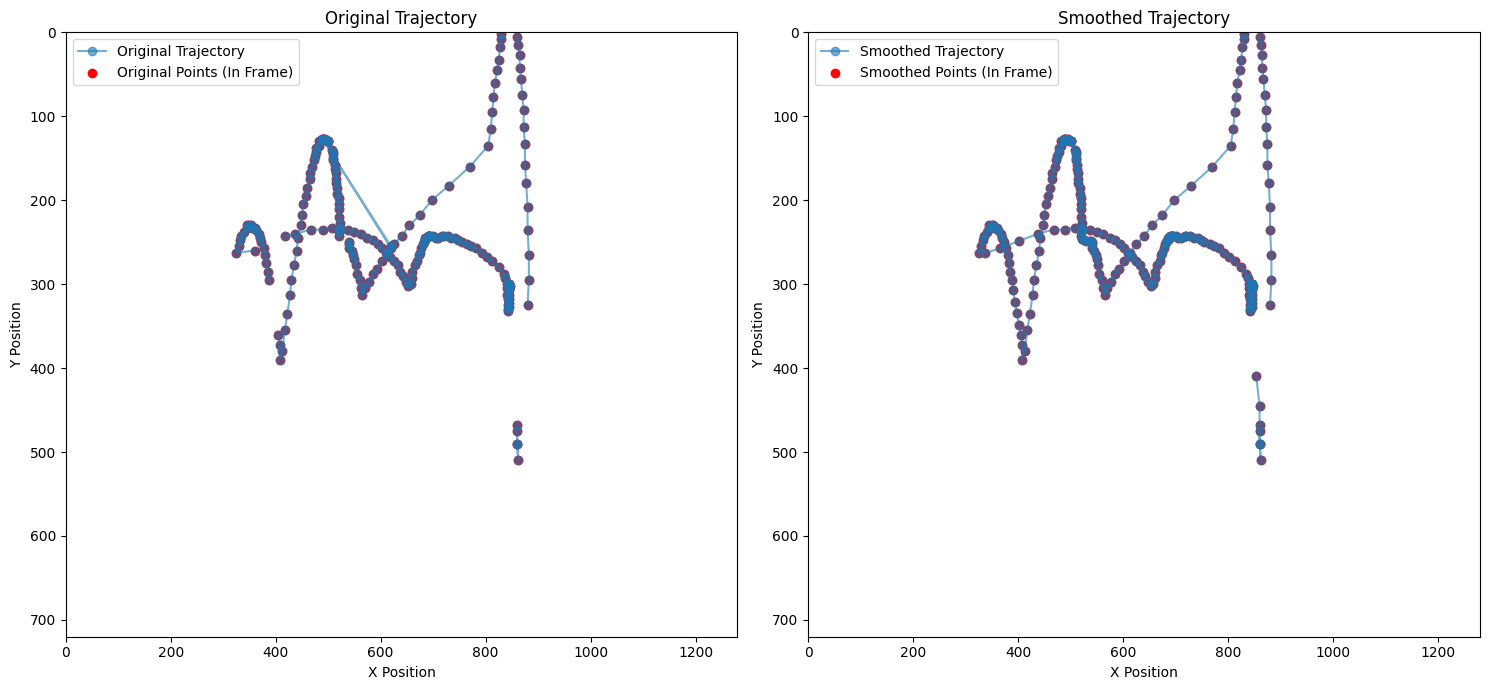

In [135]:
# Smoothen the trajectory
ball_positions_after = smoothen_trajectory(ball_positions2, FRAME_WIDTH, FRAME_HEIGHT, max_change=160, threshold=10, window_size=6, max_gap_length=5)

# Plot the original and smoothened trajectory
plot_smoothing(ball_positions2, ball_positions_after)

In [136]:
# get gt_positions
gt_positions = [x['ground_truth_position'] for x in clip_1]
original_predictions = [x['predicted_position'] for x in clip_1]
smoothed_predictions = [(x[0], x[1]) for x in ball_positions_after]

# create df
df = pd.DataFrame({'predicted_position': original_predictions, 'ground_truth_position': gt_positions, 'smoothed_position': smoothed_predictions})

# if predictied position is None set to -1, -1
df['predicted_position'] = df['predicted_position'].apply(lambda x: (-1, -1) if x == (None, None) else x)

# if ground truth position is -2,5 -2.5 set to -1, -1
df['ground_truth_position'] = df['ground_truth_position'].apply(lambda x: (-1, -1) if x == (-2.5, -2.5) else x)

# if smoothed position is nan set to -1, -1
df['smoothed_position'] = df['smoothed_position'].apply(lambda x: (-1, -1) if np.isnan(x[0]) else x)

df.sample(10)

,predicted_position,ground_truth_position,smoothed_position
170,"(487.5, 127.5)","(487.5, 130.0)","(487.5, 127.5)"
62,"(-1, -1)","(812.5, 437.5)","(-1, -1)"
75,"(882.5, 295.0)","(880.0, 295.0)","(882.5, 295.0)"
87,"(865.0, 27.5)","(862.5, 27.5)","(865.0, 27.5)"
36,"(-1, -1)","(-1, -1)","(-1, -1)"
196,"(-1, -1)","(400.0, 345.0)","(401.3064039051444, 348.3478450307391)"
21,"(-1, -1)","(-1, -1)","(-1, -1)"
72,"(-1, -1)","(-1, -1)","(-1, -1)"
144,"(520.0, 220.0)","(520.0, 220.0)","(520.0, 220.0)"
115,"(655.0, 230.0)","(655.0, 230.0)","(655.0, 230.0)"


In [137]:
# calculae metrics for row 
def calculate_metrics(row, threshold=4, comparison = 'smoothed_position'):
    predicted_position = row[comparison]
    actual_position = row['ground_truth_position']

    if actual_position == (-1,-1) and predicted_position == (-1,-1):
        # true negative
        return 0, 0, 1, 0
    elif actual_position == (-1,-1) and predicted_position != (-1,-1):
        # false positive
        return 0, 1, 0, 0
    elif actual_position != (-1,-1) and predicted_position == (-1,-1):
        # false negative
        return 0, 0, 0, 1
    else:
        if distance.euclidean(predicted_position, actual_position) < threshold:
            # true positive
            return 1, 0, 0, 0
        else:
            # false positive
            return 0, 1, 0, 0
        
def calculate_df_metrcis(frame_results_df, threshold=10, comparison='smoothed_position'):
    metrics_dict = {'Total': {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0}}
    
    for i in range(len(frame_results_df)):
        row = frame_results_df.iloc[i]

        tp, fp, tn, fn = calculate_metrics(row, threshold, comparison)

        # total metrics
        metrics_dict['Total']['tp'] += tp
        metrics_dict['Total']['fp'] += fp
        metrics_dict['Total']['tn'] += tn
        metrics_dict['Total']['fn'] += fn
    
    return metrics_dict

def calculate_agg_metrics(tp, fp, tn, fn):
    # Calculate metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    metrics = {'Accuracy': accuracy, 'F1 Score': f1, 'Precision': precision, 'Recall': recall}
    return metrics

def calculate_positioning_error(frame_results_df, threshold=10, comparison='smoothed_position'):
    positioning_error = []
    for i in range(len(frame_results_df)):
        row = frame_results_df.iloc[i]
        predicted_position = row[comparison]
        actual_position = row['ground_truth_position']

        if actual_position != (-1,-1) and predicted_position != (-1,-1):
            error = distance.euclidean(predicted_position, actual_position)
            positioning_error.append(error)

    # get mean PE
    mean_positioning_error = np.mean(positioning_error)

    # get mean PE below TH
    mean_positioning_error_below_th = np.mean([pe for pe in positioning_error if pe < threshold])

    # count bins for 0, 1,2,3,4,1000
    bins = [0, 1, 2, 3, 4, 5, 10, 100000]

    # create counts
    counts = np.bincount(np.digitize(positioning_error, bins))
    
    return counts, mean_positioning_error, mean_positioning_error_below_th

comparisons = ['smoothed_position', 'predicted_position']

for comparison in comparisons:
    metrics = calculate_df_metrcis(df, comparison=comparison)
    tp = metrics['Total']['tp']
    fp = metrics['Total']['fp']
    tn = metrics['Total']['tn']
    fn = metrics['Total']['fn']
    agg_metrics = calculate_agg_metrics(tp, fp, tn, fn)
    counts, mean_positioning_error, mean_positioning_error_below_th = calculate_positioning_error(df, comparison=comparison)
    print(f"Metrics for {comparison}")
    print(agg_metrics)
    print(f"Mean Positioning Error: {mean_positioning_error}")
    print(f"Mean Positioning Error Below Threshold: {mean_positioning_error_below_th}")
    print(f"Positioning Error Counts: {counts}")
    print("\n")


Metrics for smoothed_position
{'Accuracy': 0.9533333333333334, 'F1 Score': 0.968609865470852, 'Precision': 0.972972972972973, 'Recall': 0.9642857142857143}
Mean Positioning Error: 1.7211439997204985
Mean Positioning Error Below Threshold: 1.4730063230876762
Positioning Error Counts: [  0 111   0  83   8   3  11   3]


Metrics for predicted_position
{'Accuracy': 0.93, 'F1 Score': 0.9517241379310346, 'Precision': 0.9857142857142858, 'Recall': 0.92}
Mean Positioning Error: 3.0754077055267803
Mean Positioning Error Below Threshold: 1.3371491672679359
Positioning Error Counts: [  0 111   0  83   6   0   7   2]




## Evaluate Pipeline on test set

In [13]:
# convert test_predictions to df
test_predictions_df = pd.DataFrame(test_predictions)
test_predictions_df.sample(10)

,subset,video,clip,frame,points,window_index,predicted_position,ground_truth_position
968,New,Video_3,clip_8,209,"[{'x': 779, 'y': 270, 'visibility': 'Difficult'}]",194,"(775.0, 267.5)","(777.5, 270.0)"
1872,New,Video_6,clip_1,209,"[{'x': 361, 'y': 234, 'visibility': 'Visible'}]",376,"(360.0, 232.5)","(360.0, 232.5)"
1053,New,Video_4,clip_7,38,"[{'x': 579, 'y': 266, 'visibility': 'Difficult'}]",211,"(577.5, 265.0)","(577.5, 265.0)"
1381,New,Video_5,clip_6,48,"[{'x': 650, 'y': 281, 'visibility': 'Visible'}]",278,"(645.0, 292.5)","(650.0, 280.0)"
2553,TrackNet,game6,Clip4,248,"[{'x': 662, 'y': 94, 'visibility': 'Visible'}]",514,"(660.0, 92.5)","(660.0, 92.5)"
1171,New,Video_4,clip_7,156,"[{'x': 738, 'y': 260, 'visibility': 'Visible'}]",235,"(737.5, 260.0)","(737.5, 260.0)"
1590,New,Video_5,clip_6,257,"[{'x': 580, 'y': 304, 'visibility': 'Visible'}]",320,"(580.0, 305.0)","(580.0, 302.5)"
61,New,Video_1,clip_6,114,"[{'x': 420, 'y': 614, 'visibility': 'Visible'}]",12,"(420.0, 612.5)","(420.0, 612.5)"
1291,New,Video_5,clip_5,618,"[{'x': 600, 'y': 280, 'visibility': 'Visible'}]",260,"(597.5, 280.0)","(600.0, 280.0)"
1441,New,Video_5,clip_6,108,"[{'x': 601, 'y': 334, 'visibility': 'Visible'}]",290,"(600.0, 332.5)","(600.0, 332.5)"


In [152]:
# get distinct values for subset, video and clip
unique_values = test_predictions_df[['subset', 'video', 'clip']].drop_duplicates().values

# create a list to store the result dfs
results = []

# iterate over the unique values
for subset, video, clip in unique_values:
    # get the subset, video and clip
    subset_df = test_predictions_df[(test_predictions_df['subset'] == subset) & (test_predictions_df['video'] == video) & (test_predictions_df['clip'] == clip)]

    # sort by int(frame)
    subset_df = subset_df.sort_values(by='frame', key=lambda x: x.astype(int))
    
    # replace -2.5 with None
    subset_df['ground_truth_position'] = subset_df['ground_truth_position'].apply(lambda x: (-1, -1) if x == (-2.5, -2.5) else x)

    # extract the ball positions as np array
    ball_positions = np.array([[x[0] , x[1]] for x in subset_df['predicted_position'].values])

    # smoothen the trajectory
    ball_positions_after = smoothen_trajectory(ball_positions, FRAME_WIDTH, FRAME_HEIGHT, max_change=160, threshold=10, window_size=5, max_gap_length=10)

    # get gt_positions
    gt_positions = subset_df['ground_truth_position'].values
    original_predictions = subset_df['predicted_position'].values
    smoothed_predictions = [(x[0], x[1]) for x in ball_positions_after]
    frame = subset_df['frame'].values
    key = f"{subset}_{video}_{clip}"

    # create df
    subset_df = pd.DataFrame({'key':key ,'frame':frame,'predicted_position': original_predictions, 'ground_truth_position': gt_positions, 'smoothed_position': smoothed_predictions})

    # add to results
    results.append(subset_df)

# concat the results
results_df = pd.concat(results)

# if predictied position is None set to -1, -1
results_df['predicted_position'] = results_df['predicted_position'].apply(lambda x: (-1, -1) if x == (-2.5, -2.5) else x)

# if ground truth position is -2,5 -2.5 set to -1, -1
results_df['ground_truth_position'] = results_df['ground_truth_position'].apply(lambda x: (-1, -1) if x == (-2.5, -2.5) else x)

# if smoothed position is nan set to -1, -1
results_df['smoothed_position'] = results_df['smoothed_position'].apply(lambda x: (-1, -1) if np.isnan(x[0]) else x)

comparisons = ['smoothed_position', 'predicted_position']

for comparison in comparisons:
    metrics = calculate_df_metrcis(results_df, comparison=comparison)
    tp = metrics['Total']['tp']
    fp = metrics['Total']['fp']
    tn = metrics['Total']['tn']
    fn = metrics['Total']['fn']
    agg_metrics = calculate_agg_metrics(tp, fp, tn, fn)
    counts, mean_positioning_error, mean_positioning_error_below_th = calculate_positioning_error(results_df, comparison=comparison)
    print(f"Metrics for {comparison}")
    print(agg_metrics)
    print(f"Mean Positioning Error: {mean_positioning_error}")
    print(f"Mean Positioning Error Below Threshold: {mean_positioning_error_below_th}")
    print(f"Positioning Error Counts: {counts}")
    print("\n")


Metrics for smoothed_position
{'Accuracy': 0.8978102189781022, 'F1 Score': 0.9379222972972974, 'Precision': 0.9339781328847772, 'Recall': 0.9418999151823579}
Mean Positioning Error: 8.416746659137424
Mean Positioning Error Below Threshold: 1.845783282962361
Positioning Error Counts: [  0 936  10 837 260  20 158 132]


Metrics for predicted_position
{'Accuracy': 0.8825165102537366, 'F1 Score': 0.9278394534585824, 'Precision': 0.9572687224669604, 'Recall': 0.90016570008285}
Mean Positioning Error: 8.552289940472676
Mean Positioning Error Below Threshold: 1.7331660022702744
Positioning Error Counts: [  0 949   0 845 253   0 126  76]


